# TP 2 - Organizacion de Datos

## Oh La La... Data!


* **Aymeryc COUSAERT** ------  *Padrón 105464 - Alumno regular de intercambio.*
* **Mariana VINYOLAS**  ---------  *Alumna oyente.*

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import re
import nltk.corpus
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Importamos el dataset

Hacemos ademas un procesamiento del texto para eliminar stopwords y caracteres

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('train.csv')

In [4]:
df['text'] = df['text'].str.lower()

def clean_str(string):
    string = re.sub(r'https?\://\S+', '', string)
    string = re.sub(r'http?\://\S+', '', string)
    string = re.sub(r'@\w*\s', '', string)
#     string = re.sub(r'#\w*\s', '', string)
    string = re.sub(r'\d', '', string)
    return string

df['text_clean'] = df['text'].apply(lambda x: clean_str(str(x)))

In [5]:
# eliminamos stopwords
stop = stopwords.words('english')

df['text_clean'] = df['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# eliminamos signos de puntuacion y caracteres especiales
df['text_clean'] = df['text_clean'].str.replace('[^\w\s]','')

In [6]:
pd.set_option('display.max_colwidth', 100)

In [7]:
df[['text', 'text_clean']].sample(5)

,text,text_clean
3618,let's fraction the vital need for our fatalities. how would you break it down in #education #ec...,lets fraction vital need fatalities would break education econom
2669,@woundedpigeon http://t.co/s9soaevcvo detonate by @apollobrown ft. m.o.p.,detonate ft mop
5944,//kinda screamed &gt;_&lt; https://t.co/msuy4qtpk9,kinda screamed gt_lt
3868,if you have an opinion and you don't put it on thh internet you will furst into flames.,opinion put thh internet furst flames
115,320 [ir] icemoon [aftershock] | http://t.co/vam5podgyw | @djicemoon | #dubstep #trapmusic #dnb #...,ir icemoon aftershock dubstep trapmusic dnb edm dance icesû_


In [8]:
X = df['text_clean'].values 
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)      

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5329,), (2284,), (5329,), (2284,))

In [9]:
vocab_size = 50000
# vocab_size = len(word_index)+1
embedding_dim = 64
max_length = 100
padding_type='post'
oov_tok = "<OOV>" 

In [10]:

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index

In [11]:
# Pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)

## Entrenamos una red neuronal con Embedding


In [12]:
# instanciamos el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.LSTM(60, return_sequences=True,name='lstm_layer'),
    tf.keras.layers.Conv1D( filters=5 ,kernel_size=5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])


model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam',metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           3200000   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 5)             1605      
_________________________________________________________________
global_average_pooling1d (Gl (None, 5)                 0         
_________________________________________________________________
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 100)               600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [13]:
num_epochs = 3  # mayor num de epochs, mayor tiempo de train
batch_size = 25  # a mayor tamaño de batch, menor tiempo de entrenamiento
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/3
214/214 [==============================] - 16s 73ms/step - loss: 0.6820 - accuracy: 0.5705 - val_loss: 0.6541 - val_accuracy: 0.5722
Epoch 2/3
214/214 [==============================] - 15s 71ms/step - loss: 0.5311 - accuracy: 0.7215 - val_loss: 0.4650 - val_accuracy: 0.7859
Epoch 3/3
214/214 [==============================] - 16s 72ms/step - loss: 0.3486 - accuracy: 0.8533 - val_loss: 0.4866 - val_accuracy: 0.7942


## Visualizacion del training


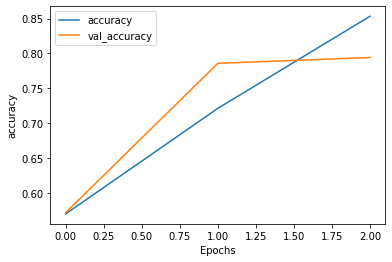

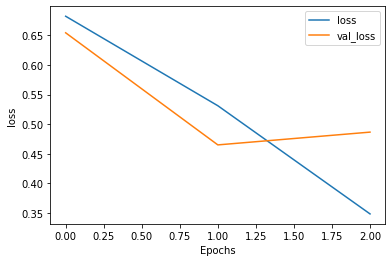

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [15]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9187
Testing Accuracy:  0.7942


### Unificamos el dataset para entrenar el modelo con la totalidad de los datos

In [16]:
train_x = df['text_clean'].values 
train_y = df['target'].values


In [17]:

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(list(train_x))
X_train = tokenizer.texts_to_sequences(train_x)
# X_test = tokenizer.texts_to_sequences(X_test)


In [18]:
# Pad sequences with zeros
train_x = pad_sequences(X_train, padding='post', maxlen=max_length)


In [19]:
model.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_size)

Epoch 1/3
305/305 [==============================] - 22s 73ms/step - loss: 0.6466 - accuracy: 0.6516
Epoch 2/3
305/305 [==============================] - 24s 80ms/step - loss: 0.4336 - accuracy: 0.8020
Epoch 3/3
305/305 [==============================] - 22s 73ms/step - loss: 0.3298 - accuracy: 0.8618


## Predicciones en el test set

Procesamos el dataset **test** para predecir sus labels

In [20]:
test = pd.read_csv('test.csv')

test['text'] = test['text'].str.lower()

def clean_str(string):
    string = re.sub(r'https?\://\S+', '', string)
    string = re.sub(r'http?\://\S+', '', string)
    string = re.sub(r'@\w*\s', '', string)
#     string = re.sub(r'#\w*\s', '', string)
    string = re.sub(r'\d', '', string)
    return string

test['text_clean'] = test['text'].apply(lambda x: clean_str(str(x)))



stop = stopwords.words('english')

test['text_clean'] = test['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# eliminamos signos de puntuacion y caracteres especiales
test['text_clean'] = test['text_clean'].str.replace('[^\w\s]','')

In [21]:
test[['text', 'text_clean']].sample(5)

,text,text_clean
1000,a demolished palestinian village comes back to life http://t.co/jsf5ofb3m6 via @wagingnv http://...,demolished palestinian village comes back life via
2268,legionnaires' disease: what's being done to stop deadly outbreak http://t.co/ud96b7thsv,legionnaires disease whats done stop deadly outbreak
798,bin laden family plane crashed after 'avoiding microlight and landing too far down runway': thre...,bin laden family plane crashed avoiding microlight landing far runway three members t
2709,i was there to see @jimmiejohnson wreck in 2000 in person. my first thought was he's leaving on ...,see wreck person first thought hes leaving stretcher
1880,@bluecurls8 @worthfull1 you basically decide to do absolutely nothing else for months and then h...,basically decide absolutely nothing else months beta hold chapters hostage


In [22]:
test_tweets = test['text_clean'].values

# Creamos las sequencias
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(test_tweets)
test_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           
    
classes = (model.predict(test_padded) > 0.5).astype("int32")


In [23]:
classes = pd.DataFrame(classes, columns=[ 'target'] )

In [24]:
classes.head(2)

,target
0,1
1,0


In [25]:
test.head(2)

,id,keyword,location,text,text_clean
0,0,NaN,NaN,just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"heard about #earthquake is different cities, stay safe everyone.",heard earthquake different cities stay safe everyone


In [26]:
test['target'] = classes['target']

In [27]:
results = test[['id', 'target']]

In [28]:
results.head(2)

,id,target
0,0,1
1,2,0


In [29]:
# importamos el archivo para hacer el submit en Kaggle
results.to_csv('results.csv', index=False)